Number of categories:  8
               categories number of files
0      dyed-lifted-polyps             500
1  dyed-resection-margins             500
2             esophagitis             500
3            normal-cecum             500
4          normal-pylorus             500
5           normal-z-line             500
6                  polyps             500
7      ulcerative-colitis             500
X shape: (4000, 30000)
y shape: (4000,)
Training Accuracy: 100.00%
Testing Accuracy (Validation Accuracy): 31.50%


<Figure size 1000x700 with 0 Axes>

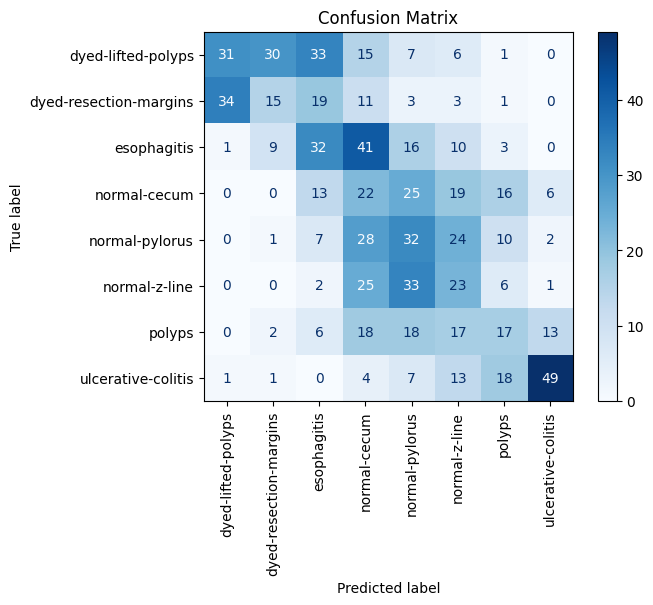

Mean Squared Error: 3.2685196530437963
R² Score: 0.3831206803761844
Precision: 0.31496581767679593
Recall: 0.27625
F1 Score: 0.2859256935080143


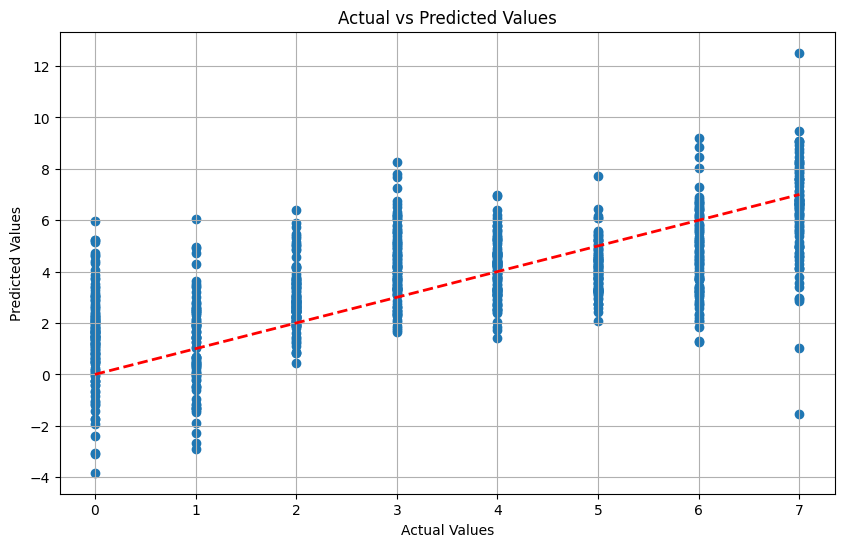

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error, r2_score, confusion_matrix,
    ConfusionMatrixDisplay, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt

# Configure the data set
dataset_dir = "/content/drive/MyDrive/kvasir-dataset V1"

def get_dataCategories(dataset_dir):
    import glob
    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))
    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])

categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categories": categories, "number of files": nbr_files})
print("Number of categories: ", len(categories))
print(df)

# Create the dataset
def create_dataset(datadir, categories, img_wid, img_high):
    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)  # This should correspond to your target variable
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                if img_array is not None:  # Check if image read correctly
                    img_resized = cv2.resize(img_array, (img_wid, img_high))
                    X.append(img_resized)
                    y.append(class_num)  # Use class_num as the target variable
            except Exception as e:
                print(f"Error reading {img}: {e}")

    X = np.array(X).reshape(len(y), -1)  # Flatten the images
    y = np.array(y)
    return X, y

img_wid, img_high = 100, 100
X, y = create_dataset(dataset_dir, categories, img_wid, img_high)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Convert continuous predictions to class labels for training and testing
y_pred_train_classes = np.clip(np.round(y_pred_train), 0, len(categories) - 1).astype(int)
y_pred_test_classes = np.clip(np.round(y_pred_test), 0, len(categories) - 1).astype(int)

# Calculate training accuracy
train_accuracy = precision_score(y_train, y_pred_train_classes, average='weighted')
test_accuracy = precision_score(y_test, y_pred_test_classes, average='weighted')

# Print the results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy (Validation Accuracy): {test_accuracy * 100:.2f}%")

# Proceed with confusion matrix and other evaluations

# Convert continuous predictions to class labels
# You can adjust the bins depending on how you want to categorize the predictions
y_pred_classes = np.clip(np.round(y_pred), 0, len(categories) - 1).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes, labels=range(len(categories)))

# Plot the confusion matrix with rotated x-axis labels
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)  # Rotate x-axis labels by 90 degrees
plt.title('Confusion Matrix')
plt.show()


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print precision, recall, and F1 score
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Optional: Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # 45-degree line
plt.grid()
plt.show()
